In [22]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from lib.layers import LinOSSModel
from lib.dataset import PDEDataset
from lib.utils import relative_l2_error

In [23]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [24]:
torch.manual_seed(0)
np.random.seed(0)

In [25]:
N_TRAIN = 64 # number of training samples
BATCH_SIZE = 64
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
training_data = PDEDataset("data/train_sol.npy", device=DEVICE)
# choose N_TRAIN samples randomly
val_data, train_data = torch.utils.data.random_split(training_data, [N_TRAIN, len(training_data) - N_TRAIN])

In [27]:
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

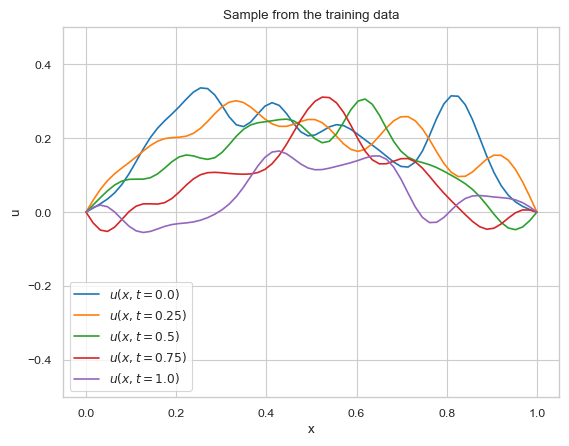

In [28]:
# plot a random sample from the training data
sample = training_data.data[np.random.randint(0, len(train_data))]
for t in range(len(sample)):
    plt.plot(
        sample[t, :, 1].cpu().numpy(),
        sample[t, :, 0].cpu().numpy(), label=f'$u(x, t={t / 4})$')

plt.ylim(-0.5, 0.5)
plt.xlabel("x")
plt.ylabel("u")
plt.title("Sample from the training data")
plt.legend()

In [29]:
learning_rate = 0.001
epochs = 500
step_size = 10
gamma = 0.75

In [30]:
model = LinOSSModel(
    input_dim=64,
    output_dim=64,
    hidden_dim=128,
    num_layers=3,
).to(DEVICE)

In [31]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, "min", patience=step_size
# )
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=step_size, eta_min=1e-6
)

In [32]:
model.train()

metrics = {
    "training_loss": [],
    "validation_loss": [],
    "lr": [],
}

progress_bar = tqdm.tqdm(range(epochs))
for epoch in progress_bar:
    train_loss = 0.0
    for input, target in train_data_loader:
        optimizer.zero_grad()

        input = input[..., 0]
        prediction = model(input).squeeze(-1)

        loss = relative_l2_error(prediction, target[..., 1:, :], dim=None)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_data_loader)

    # Compute validation loss
    validation_relative_l2 = 0.0
    for input, target in val_data_loader:
        input = input[..., 0]

        with torch.no_grad():
            prediction = model(input).squeeze(-1)

        loss = torch.sum(relative_l2_error(prediction, target[..., 1:, :]))
        validation_relative_l2 += loss.item()

    validation_relative_l2 /= len(val_data)

    metrics["training_loss"].append(train_loss)
    metrics["lr"].append(scheduler.get_last_lr())
    metrics["validation_loss"].append(validation_relative_l2)

    scheduler.step(validation_relative_l2)

    progress_bar.set_postfix(
        {
            "train_loss": train_loss,
            "val_loss": validation_relative_l2,
        }
    )


100%|██████████| 500/500 [00:06<00:00, 76.06it/s, train_loss=0.0374, val_loss=0.343]


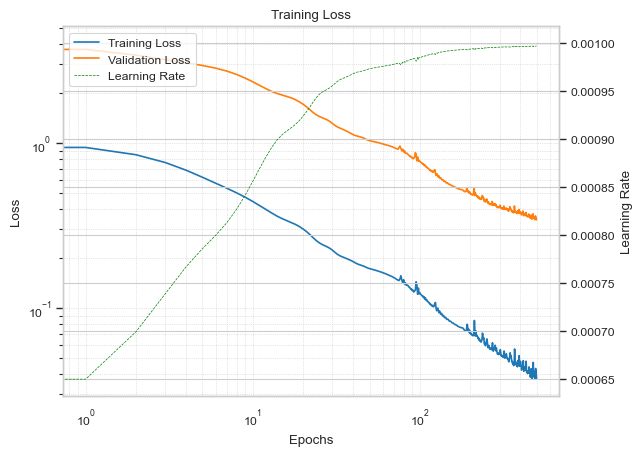

In [33]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1 = ax1.loglog(metrics["training_loss"], label="Training Loss")
l2 = ax1.loglog(metrics["validation_loss"], label="Validation Loss")
l3 = ax2.plot(metrics["lr"], label="Learning Rate", color="green", linestyle="--", linewidth=0.5)

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Learning Rate")
plt.title("Training Loss")

plt.legend(l1 + l2 + l3, [l.get_label() for l in l1 + l2 + l3])
ax1.grid(True, which="both", ls=":", linewidth=0.5)
plt.show()

In [34]:
test_data = PDEDataset("data/test_sol.npy", device=DEVICE)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [35]:
model.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for input, target in progress_bar:
        input = input[..., 0]
        target = target[..., 1:, :]
        prediction = model(input).squeeze(-1)

        loss = torch.sum(relative_l2_error(prediction, target))
        test_relative_l2 += loss.item()
    test_relative_l2 /= len(test_data)

test_relative_l2

100%|██████████| 2/2 [00:00<00:00, 128.59it/s]


0.3360079377889633

In [36]:
# save model to disk
torch.save(model.state_dict(), "models/fno_model.pth")

In [37]:
test_data = PDEDataset("data/test_sol.npy")
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [38]:
# pick 10 random samples and draw prediction and target
samples = DataLoader(test_data, batch_size=1, shuffle=True)

(64,)
(64,)
(64,)
(64,)
(64,)
(64,)


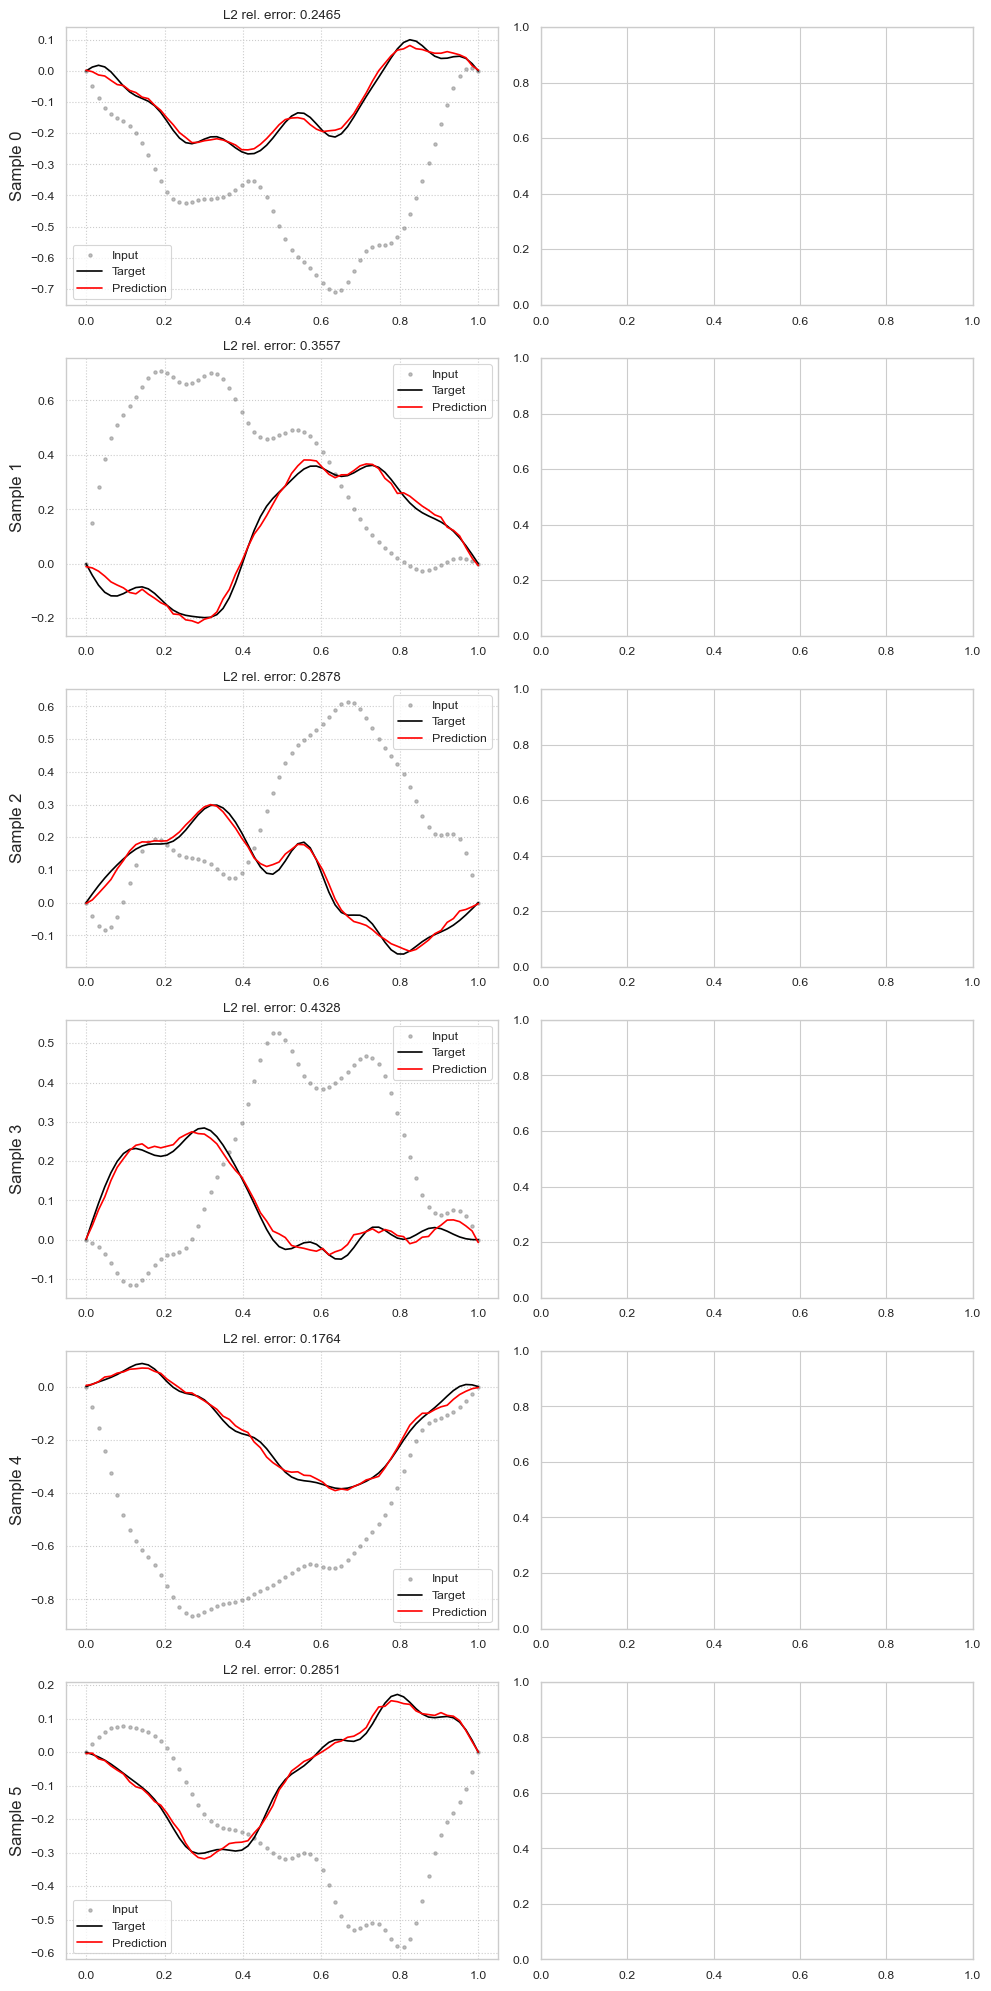

In [ ]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))

model.eval()
with torch.no_grad():
    for i, (ax_rows, sample) in enumerate(zip(axs, samples)):
        input_o, target = sample

        input = input_o[..., 0]
        target = target[..., 1:, :]

        prediction = model(input).squeeze(-1)

        re_l2_error = relative_l2_error(prediction, target).sum().item()

        ax = ax_rows[0]

        ax.set_ylabel(f"Sample {i}", fontsize=12)

        x_grid = input_o.squeeze(0).numpy()[..., 1][0]
        initial = input_o.squeeze(0).numpy()[..., 0][0]

        ax.scatter(
            x_grid,
            initial,
            label="Input",
            alpha=0.5,
            color="gray",
            marker=".",
        )

        ax.plot(
            x_grid,
            target.squeeze(0)[-1].numpy(),
            label="Target",
            color="black",
        )

        ax.plot(
            x_grid,
            prediction.squeeze(0)[-1].numpy(),
            label="Prediction",
            color="red",
        )

        ax.set_title(f"L2 rel. error: {re_l2_error:.4f}")

        ax.legend()
        ax.grid(True, which="both", ls=":")


plt.tight_layout()
plt.savefig("figures/fno_test_examples.png", dpi=300)